In [1]:
%env XLA_PYTHON_CLIENT_PREALLOCATE=false
import numpy as np
from jax import jit, random, tree_util
import jax, optax, sys, os, pickle, datetime
import flax.linen as nn
from time import time
sys.path.append(os.path.abspath('../'))
from deepmd_jax.data import SingleDataSystem
from deepmd_jax.dpmodel import DPModel
print('Program start at', datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"), 'on device:', jax.devices()[:1])
TIC = time()
# Default to use 32 bit, you can change to 16 (for mixed 16/32bit) or 64 bit (not recommended)
precision      = '32' # '16' '32' '64'
if precision == '32':
    jax.config.update('jax_default_matmul_precision', 'float32')
if precision == '64':
    jax.config.update('jax_enable_x64', True)

# DP config parameters
save_name      = 'trained_models/model_water_new.pkl' # model save name
train_data     = SingleDataSystem(['data/polaron_train/'], ['coord', 'box', 'force', 'energy'])
# train_data     = SingleDataSystem(['data/mdsim/lips/train/'], ['coord', 'box', 'force', 'energy'])
# train_data     = SingleDataSystem(['data/icewater/lw_pimd/'], ['coord', 'box', 'force', 'energy'])
# train_data     = SingleDataSystem(['data/water_chunyi/jax_data_sub'], ['coord', 'box', 'force', 'energy'])
# train_data     = SingleDataSystem(['data/Cu-dpgen/32'], ['coord', 'box', 'force', 'energy'])
use_val_data   = True # if False, comment next line
val_data       = SingleDataSystem(['data/polaron_val/'], ['coord', 'box', 'force', 'energy'])
atomic_model   = False # False for energy (global scalar) model; True for Wannier center models etc.
# val_data       = SingleDataSystem(['data/mdsim/lips/val/'], ['coord', 'box', 'force', 'energy'])
rcut           = 6.0
use_2nd_tensor = False # Use 2nd order tensor descriptor for more accuracy
use_mp         = False # Use message passing (DP-MP) model for even more accuracy (slower)  
embed_widths   = [24, 48, 96]  # Recommended width for DP model
# embed_widths   = [32, 32]      # Recommended width for DP-MP model
embedMP_widths = [64, 64, 64]  # only used in DP-MP model
fit_widths     = [128, 128, 128]
axis_neurons   = 12
batch_size     = 1
val_batch_size = 8
lr             = 0.002
s_pref_e       = 0.02
l_pref_e       = 1
s_pref_f       = 1000
l_pref_f       = 10
total_steps    = 800000
decay_steps    = 7000
decay_rate     = 0.95
print_every    = 1000

# parameters you usually don't need to change
RANDOM_SEED    = np.random.randint(1000)
beta2          = 0.99
l_smoothing    = 20
getstat_bs     = 64

train_data.compute_lattice_candidate(rcut)
if use_val_data:
    val_data.compute_lattice_candidate(rcut)
model = DPModel({'embed_widths':embed_widths,
                 'embedMP_widths':embedMP_widths if use_mp else None,
                 'fit_widths':fit_widths,
                 'axis':axis_neurons,
                 'Ebias':train_data.compute_Ebias(),
                 'rcut':rcut,
                 'use_2nd':use_2nd_tensor,
                 'use_mp':use_mp,
                 'atomic':atomic_model,})
batch, lattice_args = train_data.get_batch(getstat_bs)
static_args = nn.FrozenDict({'lattice': lattice_args, 'type_idx':tuple(train_data.type_idx)})
model.get_stats(batch['coord'], batch['box'], static_args)
print('Model statistics computed.')
variables = model.init(random.PRNGKey(RANDOM_SEED), batch['coord'][0], batch['box'][0], static_args)
print('%s Model initialized (float%s). Parameter count: %d' % ('Atomic' if atomic_model else 'Global Scalar',
            precision, sum(i.size for i in tree_util.tree_flatten(variables)[0])))
lr_scheduler = optax.exponential_decay(init_value=lr, transition_steps=decay_steps,
                    decay_rate=decay_rate, transition_begin=0, staircase=True)
optimizer = optax.adam(learning_rate=lr_scheduler, b2=beta2)
opt_state = optimizer.init(variables)
loss, loss_and_grad = model.get_loss_ef_fn()
print('Optimizer initialized. Starting training...')

state_args = {'le_avg':0., 'lf_avg':0., 'loss_avg':0., 'iteration':0}
def train_step(batch, variables, opt_state, state_args, static_args):
    r = lr_scheduler(state_args['iteration']) / lr
    pref = {'e': s_pref_e*r + l_pref_e*(1-r), 'f': s_pref_f*r + l_pref_f*(1-r)}
    (loss_total, (loss_e, loss_f)), grads = loss_and_grad(variables, batch, pref, static_args)
    updates, opt_state = optimizer.update(grads, opt_state, variables)
    variables = optax.apply_updates(variables, updates)
    for key, value in zip(['loss_avg', 'le_avg', 'lf_avg'], [loss_total, loss_e, loss_f]):
        state_args[key] = state_args[key] * (1-1/l_smoothing) + value
    state_args['iteration'] += 1
    return variables, opt_state, state_args
train_step = jit(train_step, static_argnums=(4,))

def val_step(batch, variables, static_args):
    pref = {'e': 1, 'f': 1}
    _, (loss_e, loss_f) = loss(variables, batch, pref, static_args)
    return loss_e, loss_f
val_step = jit(val_step, static_argnums=(2,))

tic = time()
for iteration in range(total_steps):
    batch, _ = train_data.get_batch(batch_size)
    variables, opt_state, state_args = train_step(batch, variables, opt_state, state_args, static_args)
    if iteration % print_every == 0:
        if use_val_data:
            val_batch, _ = val_data.get_batch(val_batch_size)
            loss_val_e, loss_val_f = val_step(val_batch, variables, static_args)
        beta = l_smoothing * (1 - (1/l_smoothing)**(iteration+1))
        print('Iter %7d' % iteration +
              ' L %7.5f' % (state_args['loss_avg']/beta)**0.5 + 
              ' LE %7.5f' % ((state_args['le_avg']/beta)**0.5/train_data.natoms) +
              ' LF %7.5f' % (state_args['lf_avg']/beta)**0.5 + 
              (' LEval %7.5f' % ((loss_val_e)**0.5/val_data.natoms) if use_val_data else '') +
              (' LFval %7.5f' % (loss_val_f)**0.5 if use_val_data else '') +
              ' Time %.2fs' % (time()-tic))
        tic = time()

with open(save_name, 'wb') as file:
    pickle.dump({'model':model, 'variables':variables}, file)
T = int(time() - TIC)
print('Model saved to \'%s\'.' % save_name)
print('Training finished in %dh %dm %ds.' % (T//3600,(T%3600)//60,T%60))

env: XLA_PYTHON_CLIENT_PREALLOCATE=false
Program start at 2023-11-02 16:09:26 on device: [cuda(id=0)]
Dataset loaded: 28928 frames/384 atoms. Path: 
	'/global/u2/r/ruiqig/deepmd-jax/examples/data/polaron_train'
Dataset loaded: 3221 frames/384 atoms. Path: 
	'/global/u2/r/ruiqig/deepmd-jax/examples/data/polaron_val'
Lattice vectors for neighbor images: Max 1 out of 1 condidates.
Lattice vectors for neighbor images: Max 1 out of 1 condidates.
Model statistics computed.
Global Scalar Model initialized (float32). Parameter count: 385890
Optimizer initialized. Starting training...
Iter       0 L 6.55433 LE 0.01780 LF 0.20726 LEval 0.11652 LFval 0.85659 Time 10.54s
Iter    1000 L 4.23659 LE 0.06691 LF 0.13384 LEval 0.00137 LFval 0.12232 Time 9.71s
Iter    2000 L 3.20993 LE 0.05086 LF 0.10141 LEval 0.06598 LFval 0.10699 Time 4.75s
Iter    3000 L 3.04271 LE 0.05083 LF 0.09612 LEval 0.00382 LFval 0.07829 Time 4.76s
Iter    4000 L 2.44861 LE 0.03110 LF 0.07738 LEval 0.06963 LFval 0.06847 Time 4.

KeyboardInterrupt: 

In [4]:
F_2YnE = [np.random.randn(2,2,10,24), np.random.randn(2,2,20,24)]
Y = 2
F1_nmE = [[F_2YnE[1,j,None] for j in range(Y)] for i in range(Y)]

TypeError: list indices must be integers or slices, not tuple

In [8]:
import numpy as np
np.arange(6).reshape(2,3).repeat(2, axis=-1)

array([[0, 0, 1, 1, 2, 2],
       [3, 3, 4, 4, 5, 5]])

In [7]:
static_args = nn.FrozenDict({'lattice': lattice_args,
                            'type_idx':tuple(train_data.type_idx),
                            'ntype_idx':tuple(lattice_args['lattice_max']*train_data.type_idx)})
type(static_args) == nn.FrozenDict

True

In [76]:
import jax_md
from jax_md import space
import jax.numpy as jnp
coord = train_data.data['coord'][0].T
coord1 = train_data.data['coord'][1].T
box = np.diag(train_data.data['box'][0].T)
displace, shift = space.periodic(box)
neighbor_list = jax_md.partition.neighbor_list(jit(displace), box, 4*rcut, 0)
nbrs = neighbor_list.allocate(coord)
CO, CH = lambda idx: jnp.where(idx < 128, idx, 384), lambda idx: jnp.where(idx < 128, 384, idx)
neighbor_list = jax_md.partition.neighbor_list(jit(displace), box, rcut, custom_mask_function=CH)
nbrs = neighbor_list.allocate(coord)
nbrs1 = neighbor_list.update(coord1, nbrs)
nbrs.idx.shape, nbrs.idx[0]


((384, 86),
 Array([128, 129, 134, 135, 140, 141, 142, 143, 144, 145, 146, 147, 159,
        166, 168, 169, 174, 175, 180, 184, 185, 200, 201, 204, 208, 209,
        212, 213, 220, 221, 222, 223, 226, 227, 230, 231, 248, 250, 251,
        254, 255, 274, 275, 286, 287, 301, 304, 312, 313, 330, 331, 334,
        335, 338, 339, 346, 347, 350, 351, 384, 384, 384, 384, 384, 384,
        384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384,
        384, 384, 384, 384, 384, 384, 384, 384], dtype=int32))

In [80]:
jnp.array([1e1000]) % 1

Array([nan], dtype=float32)

In [59]:
nbrs.idx[0], nbrs1.idx[0]

(Array([  3,   6,   7,   8,   9,  15,  19,  20,  23,  26,  28,  36,  38,
         40,  42,  46,  47,  49,  51,  61,  63,  73,  79,  92, 101, 103,
        105, 109, 111, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384,
        384, 384, 384, 384, 384, 384], dtype=int32),
 Array([  3,   7,  15,  20,  23,  26,  27,  28,  36,  38,  47,  49,  51,
         61,  63,  66,  73,  79,  82,  87,  88,  92, 105, 109, 111, 115,
        120, 121, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384,
        384, 384, 384, 384, 384, 384], dtype=int32))

In [64]:
nbrs1.did_buffer_overflow

Array(0, dtype=uint8)

In [73]:
nbrs1

In [42]:
box[0]

15.64460095

In [47]:
for k in range(384):
    nbr0 = np.array(nbrs.idx[k])
    print(np.linalg.norm((coord[k:k+1] - coord[nbr0[nbr0 < 384]] - box[0]/2) % box - box[0]/2, axis=1).max())

5.9671597261757165
5.954022587866131
5.9883719350787326
5.874228232846356
5.9024857437505895
5.986821982259769
5.8755510627797145
5.964834227300827
5.895348099378035
5.9712583522922555
5.983246943511787
5.977314612159865
5.850273268953802
5.984499960749471
5.9860632110600625
5.967160281825595
5.914256846972017
5.924467782434885
5.92769922594681
5.986659492132071
5.984499967170601
5.913999867362861
5.757033723990881
5.978033687512549
5.981869689270882
5.914915925322723
5.943948017910761
5.786123545500012
5.907687525938469
5.9380802935864265
5.999489504016006
5.953250287419022
5.998671401954201
5.9832471284971795
5.998327161398507
5.9795703760411465
5.935686611699989
5.946941239546193
5.846358657583645
5.743728752945741
5.956471609773886
5.978692010780515
5.987563444010706
5.8438610038236085
5.973614209486711
5.9115205928525745
5.960105940947571
5.975420188188221
5.838531809718836
5.938442250719883
5.983416132676483
5.986063098629414
5.991947366184056
5.927198422603117
5.92345178907444
5

In [29]:
nbrs.idx[0], nbrs.idx[0].shape

(Array([  3,   6,   7,   8,   9,  15,  19,  20,  23,  26,  28,  36,  38,
         40,  42,  46,  47,  49,  51,  61,  63,  73,  79,  92, 101, 103,
        105, 109, 111, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384,
        384, 384, 384, 384, 384, 384], dtype=int32),
 (45,))

In [48]:
nbrs

NeighborList(idx=Array([[  3,   6,   7, ..., 384, 384, 384],
       [ 10,  11,  22, ..., 384, 384, 384],
       [ 13,  16,  18, ..., 384, 384, 384],
       ...,
       [  5,   6,  12, ..., 384, 384, 384],
       [  3,   5,   6, ..., 384, 384, 384],
       [  5,   6,  12, ..., 384, 384, 384]], dtype=int32), reference_position=array([[-4.7505627 ,  3.5826297 ,  1.9345651 ],
       [ 0.23351431, -4.6879473 , -7.059005  ],
       [ 7.272841  , -6.243026  , -6.2769775 ],
       ...,
       [ 3.5051913 ,  0.35571814, -2.3954506 ],
       [ 1.1684642 ,  2.2402167 , -3.906066  ],
       [ 0.49043512,  0.82445765, -3.8168488 ]], dtype=float32), error=, cell_list_capacity=None, max_occupancy=45, format=<NeighborListFormat.Dense: 0>, cell_size=6.0, cell_list_fn=None, update_fn=<function neighbor_list.<locals>.neighbor_list_fn at 0x7f33b86096c0>)

In [31]:
(nbrs.idx < 384).sum(1).max()

Array(36, dtype=int32)

In [ ]:

def get_nbrs(coord, wh, box, rcut):
    displace, shift = space.periodic(box)
    neighbor_list = jax_md.partition.neighbor_list(jit(displace), box, rcut, 0)
    X = np.concatenate((coord, wh), axis=0)
    nbrs = neighbor_list.allocate(X)
    update = jit(neighbor_list.update)
    nbrs = update(X, nbrs)
    return neighbor_list, nbrs, update

NameError: name 'space' is not defined

In [ ]:
variables['params']

In [4]:
i = 3
e, debug = model.apply(variables, train_data.data['coord'][i], train_data.data['box'][i], static_args)
(r_NM, R_3NM, T_NXC, G0_ND, G1_ND, G2_ND, G_12_ND, G_ND, fit_n1) = debug
print('\n'.join(['%.5f' % np.std(i).item() for i in [G0_ND, G1_ND, G2_ND, G_12_ND, G_ND]]), '\n...')
print('\n'.join(['%.5f' % np.max(i).item() for i in [G0_ND, G1_ND, G2_ND, G_12_ND, G_ND]]), '\n...')
# print('\n'.join(['%.5f' % np.std(i).item() for i in [G0_ND[:,:16], G1_ND[:,:16], G2_ND[:,:16]]]))

0.33546
0.04005
0.10120
0.01354
0.14735 
...
2.15902
0.46571
1.06781
0.16159
2.15902 
...


In [6]:
2304 

144.0

In [9]:
G_ND[0],G0_ND[0],G1_ND[0], G2_ND[0] 

(Array([ 0.01916137,  0.02130562,  0.00190529, ..., -0.10251173,
        -0.2827208 , -0.204894  ], dtype=float32),
 Array([ 0.00667306,  0.02718829, -0.00279726, ...,  0.01006903,
        -0.11913715, -0.08536664], dtype=float32),
 Array([ 0.00338638, -0.00208255,  0.00075375, ..., -0.03240337,
        -0.04678294, -0.0317428 ], dtype=float32),
 Array([ 0.00910193, -0.00380012,  0.0039488 , ..., -0.08017738,
        -0.1168007 , -0.08778456], dtype=float32))

SingleDataSystem loaded from: 
 '/global/u2/r/ruiqig/deepmd-jax/examples/data/water_yifan/2'
 with 1153 frames and 192 atoms per frame.


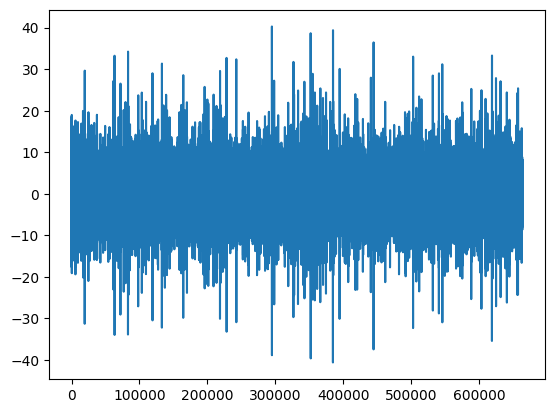

In [9]:
# train_data = SingleDataSystem(['data/water_yifan/2'], ['coord', 'box', 'force', 'energy'])
# import matplotlib.pyplot as plt
# plt.plot(train_data.data['force'].flatten())

SingleDataSystem loaded from: 
 '/global/u2/r/ruiqig/deepmd-jax/examples/data/jiayan/OPt16'
 with 11 frames and 17 atoms per frame.
Lattice vectors computed with 7 neighbor image condidates and max 5 images.


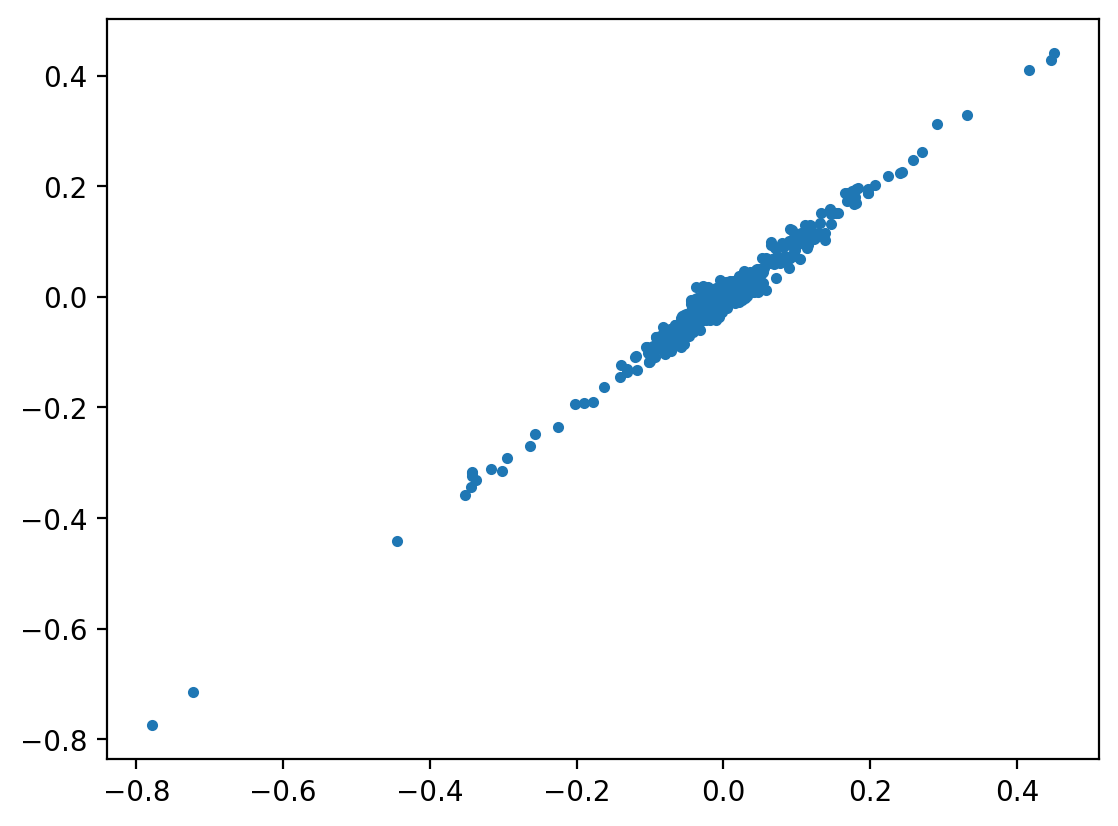

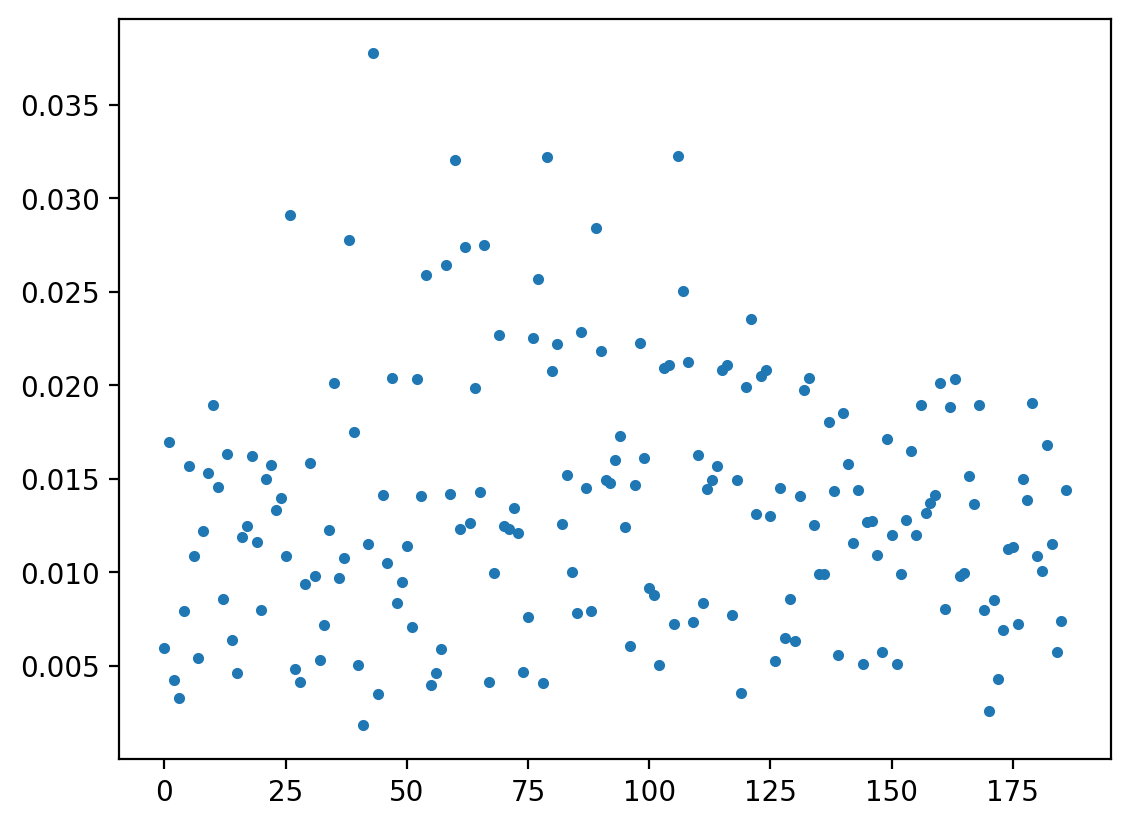

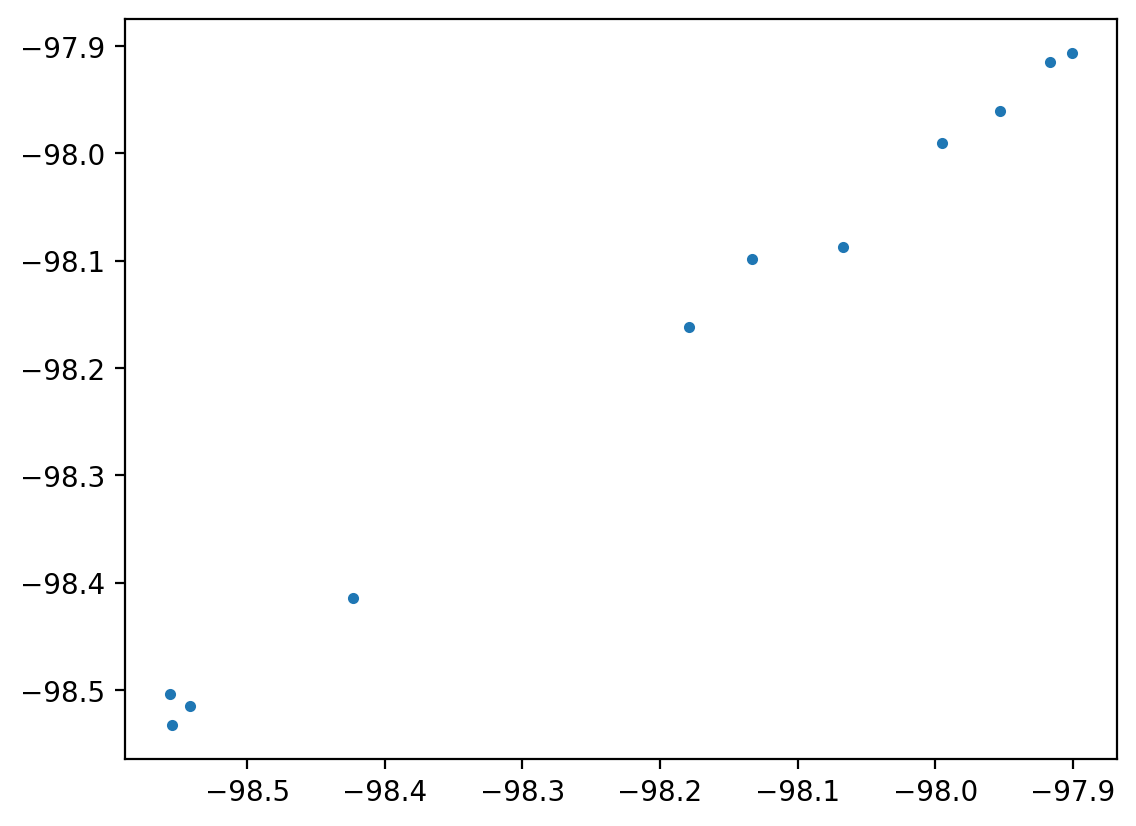

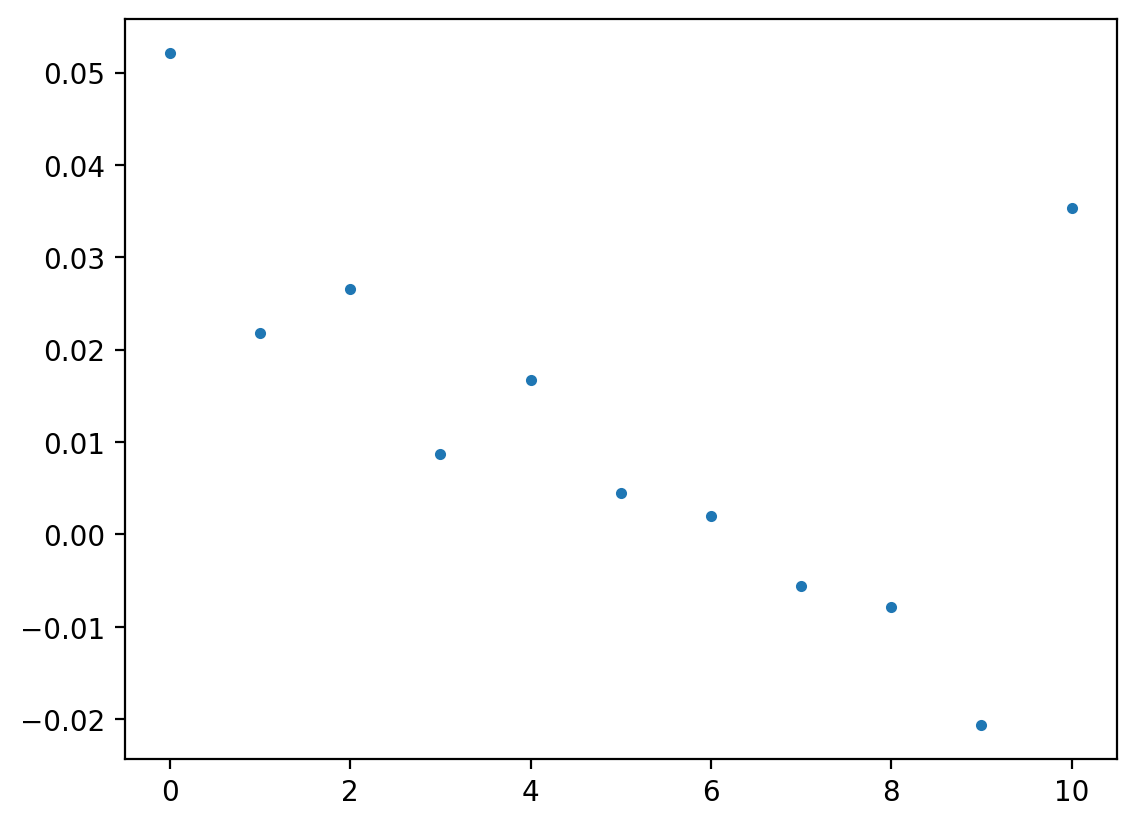

In [4]:
import matplotlib.pyplot as plt
# retina display 
%config InlineBackend.figure_format = 'retina'
from jax import vmap
with open('outdir/model_polaron_exp.pkl', 'rb') as file:
    variables = pickle.load(file)['variables']
# train_data     = SingleDataSystem(['data/jiayan/OPt16/'], ['coord', 'box', 'force', 'energy'])
train_data     = SingleDataSystem(['data/polaron_train/'], ['coord', 'box', 'force', 'energy'])
train_data.compute_lattice_candidate(rcut)
batch_size = 1
force, force_pred, energy, energy_pred = [], [], [], []
e_and_f = jit(vmap(model.energy_and_force, in_axes=(None,0,0,None)), static_argnums=(3,))
train_data.pointer = 0
for i in range(train_data.nframes//batch_size):
    batch, _ = train_data.get_batch(batch_size)
    force.append(batch['force'])
    energy.append(batch['energy'])
    e, f = e_and_f(variables, batch['coord'], batch['box'], static_args)
    force_pred.append(f)
    energy_pred.append(e)
force = np.concatenate(force, axis=0)
force_pred = np.concatenate(force_pred, axis=0)
energy = np.concatenate(energy, axis=0)
energy_pred = np.concatenate(energy_pred, axis=0)
plt.plot(force.flatten(), force_pred.flatten(), '.')
plt.figure()
ferr = ((force - force_pred)**2).mean(1)**0.5
plt.plot(ferr.flatten(), '.')
plt.figure()
plt.plot(energy, energy_pred, '.')
plt.figure()
plt.plot(energy_pred - energy, '.')

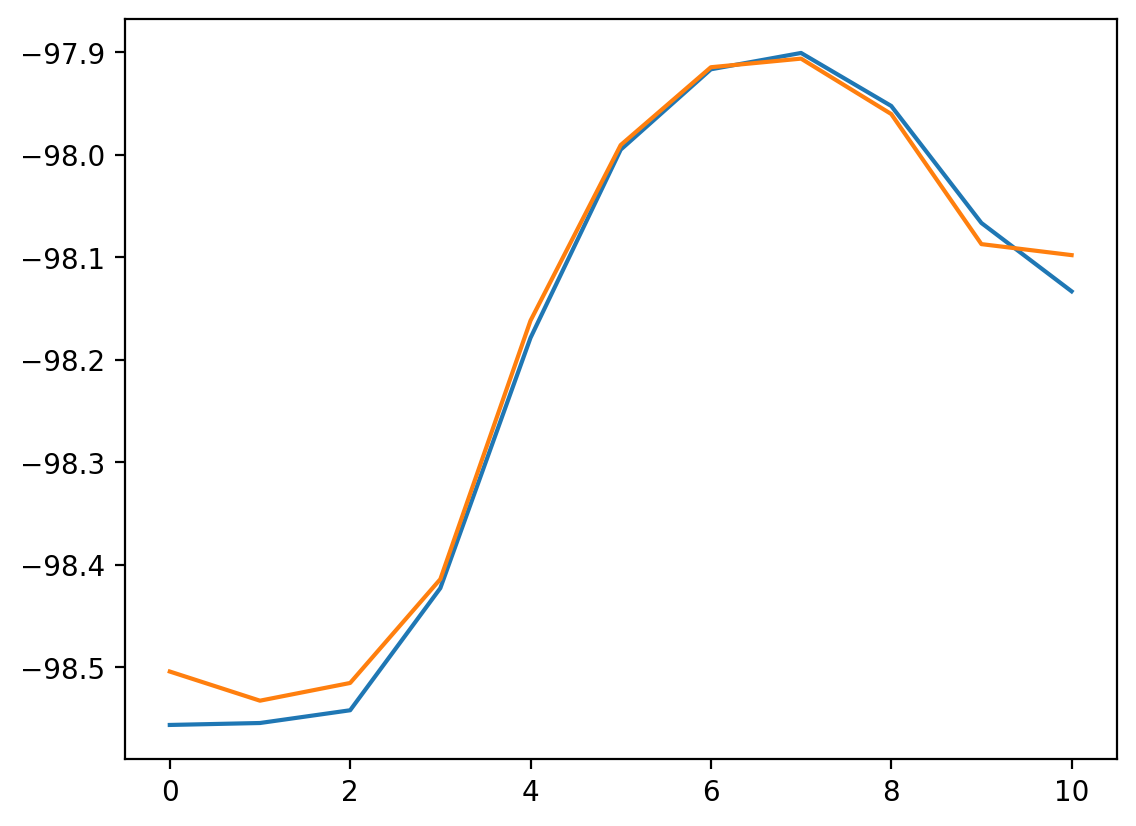

In [5]:
plt.plot(energy)
plt.plot(energy_pred)

In [2]:
import numpy as np
# path = 'data_ex6'
box = np.load('/global/homes/r/ruiqig/deepmd-jax/examples/data/water_yifan/2/set.000/box.npy').min(axis=0)
# natoms = np.load('/global/homes/r/ruiqig/deepmd-jax/examples/data/water_chunyi/data/' + path + '/set.000/coord.npy').shape[1] // 3
print(box) 
# print(natoms)

[14.659093  0.        0.        0.       13.902575  0.        0.
  0.        8.470338]


In [6]:
path = '/global/homes/r/ruiqig/deepmd-jax/examples/data/water_yifan/'
paths = [path + '1/']

In [7]:
coord, box, energy, force = [], [], [], []
for path in paths:
    coord.append(np.load(path + '/set.000/coord.npy'))
    force.append(np.load(path + '/set.000/force.npy'))
    box.append(np.load(path + '/set.000/box.npy'))
    energy.append(np.load(path + '/set.000/energy.npy'))
coord = np.concatenate(coord)
box = np.concatenate(box)
energy = np.concatenate(energy)
force = np.concatenate(force)
idx = ((box[:,::4]).min(1) > 12)
# idx = ((box[:,::4]).min(1) > 10)
print(box.shape, coord.shape, energy.shape, force.shape)
box = box[idx]
coord = coord[idx]
energy = energy[idx]
force = force[idx]
print(box.shape, coord.shape, energy.shape, force.shape)
np.save('/global/u2/r/ruiqig/deepmd-jax/examples/data/water_yifan/11/set.000/coord.npy', coord)
np.save('/global/u2/r/ruiqig/deepmd-jax/examples/data/water_yifan/11/set.000/box.npy', box)
np.save('/global/u2/r/ruiqig/deepmd-jax/examples/data/water_yifan/11/set.000/energy.npy', energy)
np.save('/global/u2/r/ruiqig/deepmd-jax/examples/data/water_yifan/11/set.000/force.npy', force)

(1517, 9) (1517, 576) (1517,) (1517, 576)
(1502, 9) (1502, 576) (1502,) (1502, 576)


In [32]:
paths = ['data%d' % i for i in range(1, 46)] + ['data_ex%d' % i for i in range(1, 7)]
paths = ['/global/homes/r/ruiqig/deepmd-jax/examples/data/water_chunyi/data/' + path for path in paths]